In [1]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.utils as utils

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Union

In [2]:
torch.manual_seed(77)

In [3]:
def imshow(img):
    img = (img + 1) / 2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()


def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()


In [4]:
standardizer = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

In [5]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
noise_dim = 100
BATHC_SIZE = 256
LEARNING_RATE = 0.001
EPOCHS = 200
N_CRITIC = 5
W_CLIP = 0.01
LAMBDA_GP = 10

In [7]:
train_data = datasets.MNIST(root='./mnist/', train=True, download=True, transform=standardizer)
test_data = datasets.MNIST(root='./mnist/', train=False, download=True, transform=standardizer)
total_train = torch.utils.data.ConcatDataset([train_data, test_data])

train_dataloader = torch.utils.data.DataLoader(dataset=total_train, batch_size=BATHC_SIZE, shuffle=True)

In [8]:
# DCGAN과 완전 동일한 generator와 discriminator를 사용한다

class wCritic(nn.Module):
    def __init__(self):
        super(wCritic, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.LayerNorm([64, 16, 16]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.LayerNorm([128, 8, 8]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def forward(self, x):
        x = self.model(x)
        x = x.view((-1, 1))
        return x

In [9]:
class wGen(nn.Module):
    def __init__(self):
        super(wGen, self).__init__()
        self.dconv = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 128, 4, 1, 0, bias=False),
            nn.LayerNorm([128, 3, 3]),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.LayerNorm([64, 5, 5]),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.LayerNorm([32, 9, 9]),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view((-1, noise_dim, 1, 1))
        x = self.dconv(x)
        return x

In [10]:
def get_z(batch_size=BATHC_SIZE):
    return cuda.FloatTensor(torch.randn(batch_size, noise_dim, device=device))

In [11]:
def get_gradient_penalty(D, real_imgs, fake_imgs):
    t = torch.randn((real_imgs.shape[0], 1, 1, 1)).to(device)
    inner_point = (t * real_imgs + (1 - t) * fake_imgs).requires_grad_(True)
    d_inner_point = D(inner_point)
    norm1 = torch.ones((real_imgs.shape[0], 1)).to(device).requires_grad_(False) #cuda.FloatTensor(torch.ones((real_imgs.shape[0], 1))).requires_grad_(False)
    grad = torch.autograd.grad(
        outputs=d_inner_point,
        inputs=inner_point,
        grad_outputs=norm1,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    grad = grad.view((grad.shape[0], -1))
    grad_penalty = (grad.norm(2, dim=1) ** 2).mean()
    return grad_penalty

In [12]:
def train(G, D, optim_G, optim_D, train_loader):
    G.train()
    D.train()
    for epoch in tqdm(range(EPOCHS)):
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            for it in range(N_CRITIC):
                optim_D.zero_grad()

                z = get_z(batch_size=imgs.shape[0])

                fake_imgs = G(z)

                gradient_penalty = get_gradient_penalty(D, imgs, fake_imgs)

                loss_d = torch.mean(D(fake_imgs)) - torch.mean(D(imgs)) + LAMBDA_GP * gradient_penalty

                loss_d.backward()
                optim_D.step()

            optim_G.zero_grad()

            gen_imgs = G(get_z())

            loss_g = -torch.mean(D(gen_imgs))

            loss_g.backward()

            optim_G.step()
            
        if epoch % 10 == 0:
            print(f'[{epoch}/{EPOCHS}] loss_d : {loss_d:.4f}, loss_g : {loss_g:.4f}')
            imshow_grid(G(get_z(batch_size=16)))

    torch.save(G, './model/wGenerator_gp.pth')
    torch.save(D, './model/wDiscriminator_gp.pth')

In [13]:
gen = wGen().to(device)
disc = wCritic().to(device)
optim_G = optim.Adam(gen.parameters(), lr=LEARNING_RATE)
optim_C = optim.Adam(disc.parameters(), lr=LEARNING_RATE)

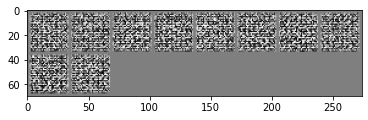

torch.Size([10, 1, 32, 32])

In [14]:
z = get_z(batch_size=10)
img_fake = gen(z).view((-1, 1, 32, 32))
imshow_grid(img_fake.cpu().detach())
img_fake.shape

  0%|          | 0/200 [00:00<?, ?it/s]

[0/200] loss_d : -9827.6387, loss_g : 933.1163


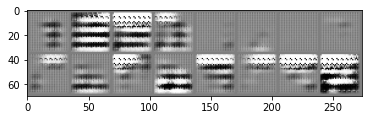

  5%|▌         | 10/200 [05:10<1:38:44, 31.18s/it]

[10/200] loss_d : 66.0165, loss_g : 17766.8906


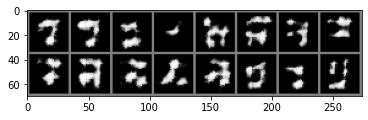

 10%|█         | 20/200 [10:19<1:33:00, 31.00s/it]

[20/200] loss_d : 455.2979, loss_g : 14711.4414


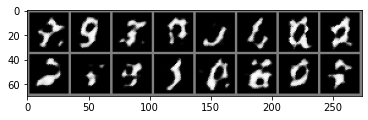

 15%|█▌        | 30/200 [15:28<1:27:30, 30.89s/it]

[30/200] loss_d : 150.3777, loss_g : 8700.1465


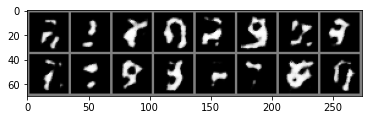

 20%|██        | 40/200 [20:37<1:22:58, 31.12s/it]

[40/200] loss_d : -10.7927, loss_g : 2205.4683


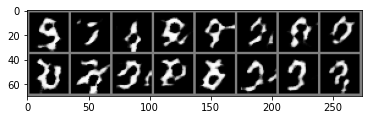

 25%|██▌       | 50/200 [25:59<1:20:22, 32.15s/it]

[50/200] loss_d : -104569.4141, loss_g : -12098.8701


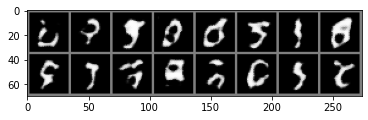

 30%|███       | 60/200 [31:12<1:12:31, 31.08s/it]

[60/200] loss_d : 2449.3491, loss_g : -278340.4062


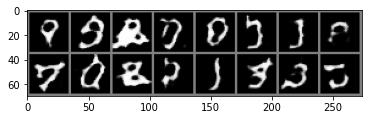

 35%|███▌      | 70/200 [36:24<1:06:58, 30.91s/it]

[70/200] loss_d : -1923822.0000, loss_g : 109583.0000


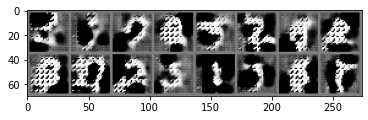

 40%|████      | 80/200 [41:33<1:01:42, 30.86s/it]

[80/200] loss_d : 6911.1792, loss_g : 1910.4341


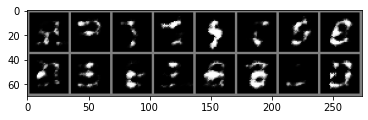

 45%|████▌     | 90/200 [46:43<56:48, 30.99s/it]  

[90/200] loss_d : 205.1408, loss_g : 41013.3242


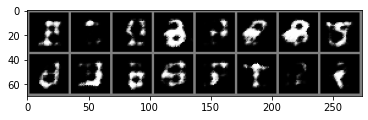

 50%|█████     | 100/200 [51:52<51:26, 30.87s/it]

[100/200] loss_d : -18573.6738, loss_g : 43716.6484


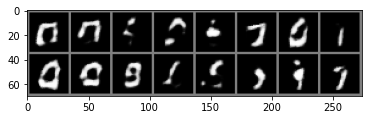

 55%|█████▌    | 110/200 [57:01<46:22, 30.92s/it]

[110/200] loss_d : 316.5627, loss_g : -1060.4742


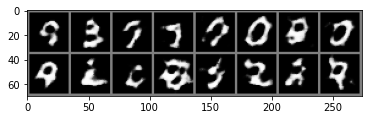

 60%|██████    | 120/200 [1:02:10<41:14, 30.93s/it]

[120/200] loss_d : 6266.3916, loss_g : -825.1793


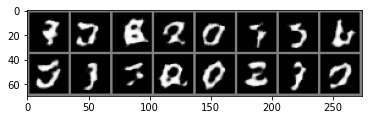

 65%|██████▌   | 130/200 [1:07:20<35:57, 30.82s/it]

[130/200] loss_d : -166174.1562, loss_g : -23449.9316


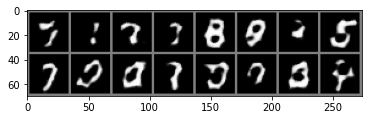

 70%|███████   | 140/200 [1:12:28<30:48, 30.81s/it]

[140/200] loss_d : -90395.2969, loss_g : -23216.2539


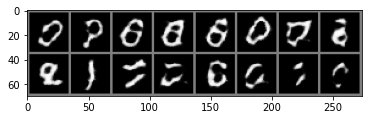

 75%|███████▌  | 150/200 [1:17:39<26:00, 31.21s/it]

[150/200] loss_d : -1018.6680, loss_g : -3382.4800


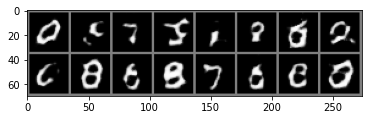

 80%|████████  | 160/200 [1:22:50<20:42, 31.07s/it]

[160/200] loss_d : -87621.0156, loss_g : -50504.9336


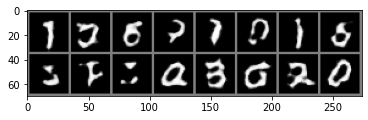

 85%|████████▌ | 170/200 [1:27:59<15:25, 30.85s/it]

[170/200] loss_d : -834.1003, loss_g : -17212.0000


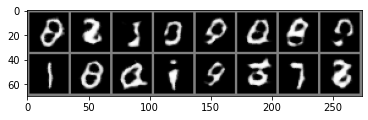

 90%|█████████ | 180/200 [1:33:08<10:16, 30.84s/it]

[180/200] loss_d : 1567.6550, loss_g : -18097.8828


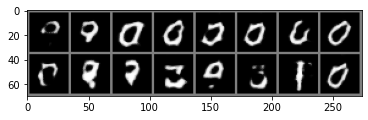

 95%|█████████▌| 190/200 [1:38:11<05:00, 30.05s/it]

[190/200] loss_d : 117349.9062, loss_g : -440203.8750


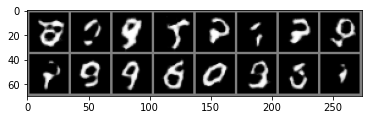

100%|██████████| 200/200 [1:43:12<00:00, 30.96s/it]


In [15]:
train(gen, disc, optim_G, optim_C, train_dataloader)

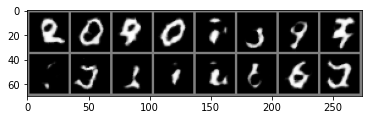

In [16]:
z = get_z(batch_size=16)
imgs = gen(z)
imshow_grid(imgs.cpu().detach())